# Vehicle Detection using Single Shot Multi-Box Detector (SSD)

paper: https://arxiv.org/pdf/1512.02325.pdf

For this I am using pre-trained pytorch SSD network by https://github.com/amdegroot/ssd.pytorch

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('ssd.pytorch'))
if module_path not in sys.path:
    sys.path.append(module_path)

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
from torch.autograd import Variable
import numpy as np
import cv2
if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')

from ssd import build_ssd

from data import VOC_CLASSES as labels

### Load the pretrained model

build_ssd creates the VGG network and defines the forward function. And then the pretrained model weights are loaded to the network.

In [2]:
net = build_ssd('test', 300, 21)    # initialize SSD
net.load_weights('pretrained/ssd300_mAP_77.43_v2.pth')

Loading weights into state dict...
Finished!


/Users/vamshichowdary/udacity/sdc_torch/vehicle-detection/ssd.pytorch/ssd.py:34: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  self.priors = Variable(self.priorbox.forward(), volatile=True)


### Test the network on an example image

image source: https://www.wired.com/story/waymo-self-driving-this-week-cars/

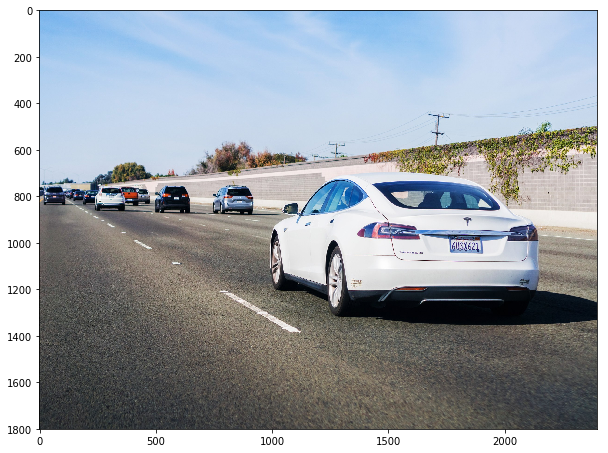

In [3]:
image = cv2.imread('data/example.jpg', cv2.IMREAD_COLOR)  # uncomment if dataset not downloaded
%matplotlib inline
from matplotlib import pyplot as plt

rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# View the sampled input image before transform
plt.figure(figsize=(10,10))
plt.imshow(rgb_image)
plt.show()

### Preprocessing

For SSD, at test time the model expects a custom BaseTransform callable to resize the image to 300x300.
The image is also subtracted from the mean rgb values of the dataset on which the SSD300 model was trained. Color channels are also swapped for input to SSD300.

See here for more details: https://github.com/amdegroot/ssd.pytorch/tree/master/demo

Visualize how the model is receiving the input

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


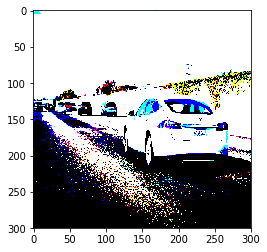

In [4]:
x = cv2.resize(image, (300, 300)).astype(np.float32)
x -= (104.0, 117.0, 123.0)
x = x.astype(np.float32)
x = x[:, :, ::-1].copy()
plt.imshow(x)
x = torch.from_numpy(x).permute(2, 0, 1)

### SSD300 Forward pass

In [5]:
xx = Variable(x.unsqueeze(0))     # wrap tensor in Variable
if torch.cuda.is_available():
    xx = xx.cuda()
y = net(xx)

### Put the bounding boxes on the detected locations and label them

The model correctly detected the main subject of our image with 100% confidence and also another car with 75% confidence. Here we defined the minimum confidence of our prediction to be 60%.

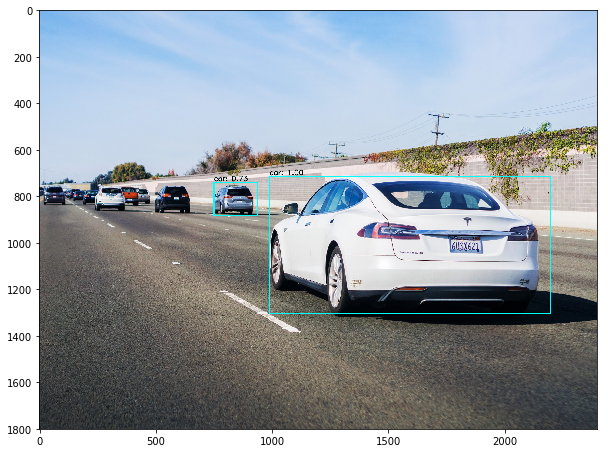

In [10]:
detections = y.data
# scale each detection back up to the image
scale = torch.Tensor(rgb_image.shape[1::-1]).repeat(2)
for i in range(detections.size(1)):
    j = 0
    
    # Only select the detections with confidence >= 60%
    while detections[0,i,j,0] >= 0.6:
        score = detections[0,i,j,0]
        label_name = labels[i-1]
        display_txt = '%s: %.2f'%(label_name, score)
        pt = (detections[0,i,j,1:]*scale).numpy()
        pt = pt.astype(int)
        cv2.rectangle(rgb_image,(pt[0], pt[1]),(pt[2], pt[3]),(0,255,255), 3)
        cv2.putText(rgb_image, display_txt,(pt[0], pt[1]-5), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0,0,0), 2, cv2.LINE_AA)
        j+=1

plt.figure(figsize=(10,10))
plt.imshow(rgb_image)  # plot the image for matplotlib

If we change the minimum confidence level to 30%, the model detects more cars far away in the field of view.
But for our final model, we set the minimum confidence level as 60%

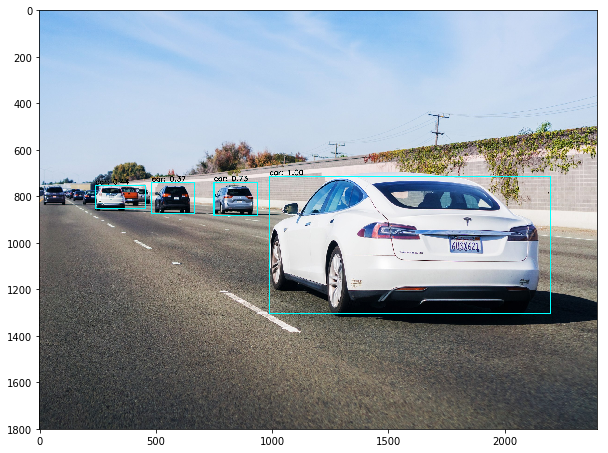

In [11]:
detections = y.data
# scale each detection back up to the image
scale = torch.Tensor(rgb_image.shape[1::-1]).repeat(2)
for i in range(detections.size(1)):
    j = 0
    
    # Only select the detections with confidence >= 30%
    while detections[0,i,j,0] >= 0.3:
        score = detections[0,i,j,0]
        label_name = labels[i-1]
        display_txt = '%s: %.2f'%(label_name, score)
        pt = (detections[0,i,j,1:]*scale).numpy()
        pt = pt.astype(int)
        cv2.rectangle(rgb_image,(pt[0], pt[1]),(pt[2], pt[3]),(0,255,255), 3)
        cv2.putText(rgb_image, display_txt,(pt[0], pt[1]-5), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0,0,0), 2, cv2.LINE_AA)
        j+=1

plt.figure(figsize=(10,10))
plt.imshow(rgb_image)  # plot the image for matplotlib

### Using OpenCV to test the model on a video

Define the process pipeline: Put the above code in a function

In [13]:
def process_pipeline(frame, verbose=False):
        img_blend_out = frame.copy()
        rgb_image = cv2.cvtColor(img_blend_out, cv2.COLOR_BGR2RGB)
        x = cv2.resize(img_blend_out, (300, 300)).astype(np.float32)
        x -= (104.0, 117.0, 123.0)
        x = x.astype(np.float32)
        x = x[:, :, ::-1].copy()
        #plt.imshow(x)
        x = torch.from_numpy(x).permute(2, 0, 1)

        xx = Variable(x.unsqueeze(0))     # wrap tensor in Variable
        if torch.cuda.is_available():
                xx = xx.cuda()
        y = net(xx)

        detections = y.data
        # scale each detection back up to the image
        scale = torch.Tensor(rgb_image.shape[1::-1]).repeat(2)
        for i in range(detections.size(1)):
                j = 0
                while detections[0,i,j,0] >= 0.6:
                        score = detections[0,i,j,0]
                        label_name = labels[i-1]
                        display_txt = '%s: %.2f'%(label_name, score)
                        pt = (detections[0,i,j,1:]*scale).cpu().numpy()
                        pt = pt.astype(int)
                        cv2.rectangle(rgb_image,(pt[0], pt[1]),(pt[2], pt[3]),(0,255,155), 3)
                        cv2.putText(rgb_image, display_txt,(pt[0], pt[1]-5), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0,0,0), 2, cv2.LINE_AA)
                        j+=1
        return rgb_image


### Test the model on a video
This code will extract each frame from the test video, perform the above detection on the frame and save the frame in the 'frames_out' folder

In [ ]:
video_file = 'data/project_video.mp4'
cap_in = cv2.VideoCapture(video_file)
video_out_dir = 'data/frames_out'
f_counter = 0
while True:
        ret, frame = cap_in.read()
        if ret:
                f_counter += 1
                frame_out = process_pipeline(frame, verbose=1)
                if not cv2.imwrite(os.path.join(video_out_dir, '{:06d}.jpg'.format(f_counter)), frame_out) :
                        print('cannot write')
                cv2.imshow('', frame_out)
                cv2.waitKey(1)
                if cv2.waitKey(1) & 0xFF == ord('q'):
                        break
# When everything done, release the capture
cap_in.release()
cv2.destroyAllWindows()
exit()


### Create the video from all the processed frames

Final processed video is stored as result.mp4 file

In [ ]:
import os

from os.path import isfile, join

pathIn = './data/frames_out/'
pathOut = './data/result.mp4'

#frame rate of the video. Framerate of a video can be read from get(cv2.CAP_PROP_FPS) function
fps = 25

#Sort the list according to file names
frame_array = []
files = [f for f in os.listdir(pathIn) if isfile(join(pathIn, f))]

# file names of the frames must be in {00xxxx.jpg} format
files.sort(key = lambda x: x[2:-4])

# read each frame using cv2 imread and append it to the frame array
for i in range(len(files)):
        filename = pathIn+files[i]
        img = cv2.imread(filename)
        ht, wd, layers = img.shape
        size = (wd, ht) 
        frame_array.append(img)

# define the output video writer
video_out = cv2.VideoWriter(pathOut, cv2.VideoWriter_fourcc(*'DIVX'), fps, size)

# Process each frame to video writer
for fr in frame_array:
        video_out.write(fr)

video_out.release()
